In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import dicom
import os
import scipy.ndimage
import cv2
import time
from IPython import display
import scipy.misc
import skimage
import skimage.measure

%matplotlib inline

size_image = (256, 216,3)

# Read files

In [2]:
PathDicom = "./TrainingSet/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [3]:
lstFilesDCM

['./TrainingSet/patient16/P16dicom/P16-0238.dcm',
 './TrainingSet/patient16/P16dicom/P16-0251.dcm',
 './TrainingSet/patient16/P16dicom/P16-0234.dcm',
 './TrainingSet/patient16/P16dicom/P16-0018.dcm',
 './TrainingSet/patient16/P16dicom/P16-0034.dcm',
 './TrainingSet/patient16/P16dicom/P16-0139.dcm',
 './TrainingSet/patient16/P16dicom/P16-0082.dcm',
 './TrainingSet/patient16/P16dicom/P16-0228.dcm',
 './TrainingSet/patient16/P16dicom/P16-0201.dcm',
 './TrainingSet/patient16/P16dicom/P16-0142.dcm',
 './TrainingSet/patient16/P16dicom/P16-0128.dcm',
 './TrainingSet/patient16/P16dicom/P16-0141.dcm',
 './TrainingSet/patient16/P16dicom/P16-0120.dcm',
 './TrainingSet/patient16/P16dicom/P16-0149.dcm',
 './TrainingSet/patient16/P16dicom/P16-0050.dcm',
 './TrainingSet/patient16/P16dicom/P16-0211.dcm',
 './TrainingSet/patient16/P16dicom/P16-0274.dcm',
 './TrainingSet/patient16/P16dicom/P16-0235.dcm',
 './TrainingSet/patient16/P16dicom/P16-0273.dcm',
 './TrainingSet/patient16/P16dicom/P16-0024.dcm',


In [3]:
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [4]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM[:1]:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    print ("num : ", lstFilesDCM.index(filenameDCM))
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

('num : ', 0)


In [6]:
ConstPixelSpacing

(0.72859744990893, 0.72859744990893, 7.0)

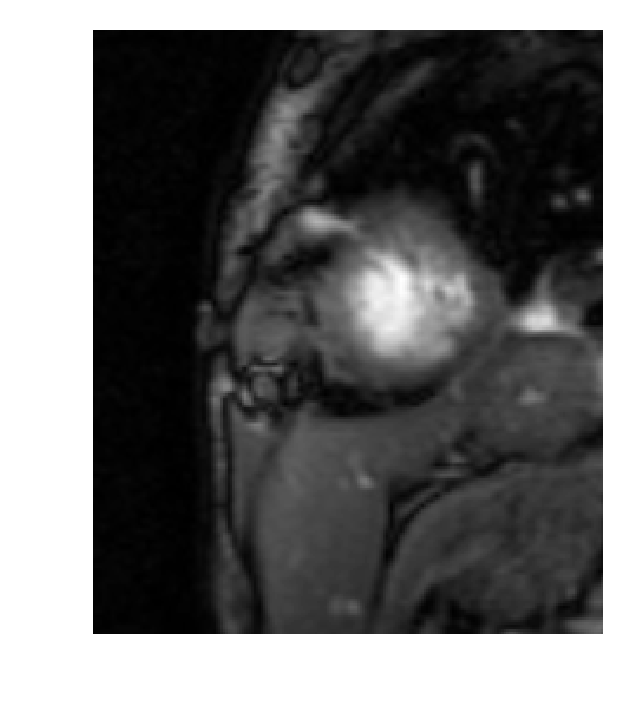

In [7]:
plt.figure(dpi=200)
plt.axis('off')
plt.imshow(ArrayDicom[:,:,0], cmap="gray")

In [8]:
lstFilesDCM[0]

'./TrainingSet/patient16/P16dicom/P16-0238.dcm'

# Read coord

## inner contour and outer contour

In [5]:
Path = "./TrainingSet/"
lstFilesI = []  # create an empty list
lstFilesO = []

for dirName, subdirList, fileList in os.walk(Path):
    for filename in fileList:
        if "icontour-manual.txt" in filename.lower():  # check whether the file's DICOM
            lstFilesI.append(os.path.join(dirName,filename))
        if "ocontour-manual.txt" in filename.lower():
            lstFilesO.append(os.path.join(dirName,filename))

In [10]:
lstFilesI

['./TrainingSet/patient16/P16contours-manual/P16-0040-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0107-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0087-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0067-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0120-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0167-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0187-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0127-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0100-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0140-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0160-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0207-icontour-manual.txt',
 './TrainingSet/patient16/P16contours-manual/P16-0200-icontour-manual.txt',
 './Training

In [6]:
def read_coord(filepath, space, height, width, valueMask):
    f = open(filepath, "r")
    lines = f.readlines()
    mask = np.zeros((height, width))
    for l in lines:
        coord = np.array([float(c) for c in l[:-1].split(" ")])
        coord = coord.astype(int)
#         print (coord)
        mask[coord[1], coord[0]] = valueMask
    
    return mask
    
nb_images = len(lstFilesI)
coordI = np.array((ConstPixelDims[0], ConstPixelDims[1], nb_images))
coordO = np.array((ConstPixelDims[0], ConstPixelDims[1], nb_images))

masks1 = np.zeros((size_image[0], size_image[1], len(lstFilesI)))
masks2 = np.zeros((size_image[0], size_image[1], len(lstFilesI)))
images = np.zeros((size_image[0], size_image[1], len(lstFilesI)))
path_images = []
for index, ifile_path in enumerate(lstFilesI):
    ifilename = os.path.basename(ifile_path)
    num_image = ifilename[0:8]
    print ("num_images : ", num_image)
    ofile_path = [filep for filep in lstFilesO if num_image in filep][0]
    img_path = [imgp for imgp in lstFilesDCM if num_image in imgp][0]
    RefDs = dicom.read_file(img_path)
    path_images.append(img_path)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]))
    try:
        masks1[:, :, index] = read_coord(ofile_path, ConstPixelSpacing, RefDs.Rows, RefDs.Columns,1)
        masks2[:, :, index] = read_coord(ifile_path, ConstPixelSpacing, RefDs.Rows, RefDs.Columns, 1)
        images[:, :, index]  = RefDs.pixel_array
    except ValueError: # if dimension issue : 216,256 instead of 256,216 we flip the image
        print ("index error : ", index)
        masks1[:, :, index] = read_coord(ofile_path, ConstPixelSpacing, RefDs.Rows, RefDs.Columns,1).T
        masks2[:, :, index] = read_coord(ifile_path, ConstPixelSpacing, RefDs.Rows, RefDs.Columns, 1).T
        images[:, :, index]  = RefDs.pixel_array.T
    
    
    
    
    
    

('num_images : ', 'P16-0040')
('num_images : ', 'P16-0107')
('num_images : ', 'P16-0087')
('num_images : ', 'P16-0067')
('num_images : ', 'P16-0120')
('num_images : ', 'P16-0167')
('num_images : ', 'P16-0187')
('num_images : ', 'P16-0127')
('num_images : ', 'P16-0100')
('num_images : ', 'P16-0140')
('num_images : ', 'P16-0160')
('num_images : ', 'P16-0207')
('num_images : ', 'P16-0200')
('num_images : ', 'P16-0060')
('num_images : ', 'P16-0080')
('num_images : ', 'P16-0180')
('num_images : ', 'P16-0147')
('num_images : ', 'P03-0140')
('num_images : ', 'P03-0148')
('num_images : ', 'P03-0120')
('num_images : ', 'P03-0068')
('num_images : ', 'P03-0080')
('num_images : ', 'P03-0108')
('num_images : ', 'P03-0060')
('num_images : ', 'P03-0128')
('num_images : ', 'P03-0100')
('num_images : ', 'P03-0088')
('num_images : ', 'P03-0040')
('num_images : ', 'P09-0160')
('num_images : ', 'P09-0107')
('num_images : ', 'P09-0140')
('num_images : ', 'P09-0120')
('num_images : ', 'P09-0060')
('num_imag

(-0.5, 215.5, 255.5, -0.5)

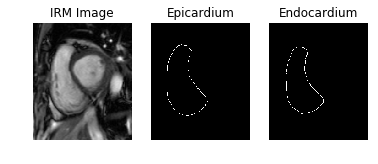

In [15]:
num_image_test = 0
img = images[:,:,num_image_test]
contour1 = masks1[:,:,num_image_test]
contour2 = masks2[:,:,num_image_test]

nbImagesToShow = 3
plt.subplot(1,nbImagesToShow,1)
plt.imshow(img, cmap="gray")
plt.title("IRM Image")
plt.axis('off')
plt.subplot(1,nbImagesToShow,2)
plt.imshow(contour1, cmap="gray")
plt.title("Epicardium")
plt.axis('off')
plt.subplot(1,nbImagesToShow,3)
plt.imshow(contour2, cmap="gray")
plt.title("Endocardium")
plt.axis('off')

## Compute the ground truth of the segmentation

We use closure morphologie in order to do that

In [12]:
complete_mask = np.zeros((size_image[0], size_image[1], len(lstFilesI)))

# kernel = np.ones((5,5),np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# We add zero padding to handle the border
zp = 10

for num_image_test in range(images.shape[2]):
# num_image_test = 36
    img = images[:,:, num_image_test]
    mask1 = masks1[:,:, num_image_test]
    mask2 = masks2[:,:, num_image_test]

    closing2 = cv2.morphologyEx(np.lib.pad(mask2,(zp,zp), 'constant') , cv2.MORPH_CLOSE, kernel, iterations=17)[zp:-zp,zp:-zp]
    closing1 = cv2.morphologyEx(np.lib.pad(mask1,(zp,zp), 'constant'), cv2.MORPH_CLOSE, kernel, iterations=18)[zp:-zp,zp:-zp]

    mask_border = closing1-closing2
    complete_mask[:,:, num_image_test] = closing2.copy()
    complete_mask[mask_border.astype(bool), num_image_test] = 2

#     plt.figure(figsize=(30,30))
#     plt.subplot(2,3,1)
#     plt.imshow(img, cmap="gray")
#     plt.title("Photo numero : " + str(num_image_test))
#     plt.subplot(2,3,2)
#     plt.imshow(mask1+mask2, cmap="gray")
#     plt.subplot(2,3,3)
#     plt.imshow(mask_border, cmap='gray')
#     plt.subplot(2,3,4)
#     # complete_mask = mask1+mask2
#     plt.imshow(complete_mask[:,:, num_image_test], cmap="gray")
#     plt.subplot(2,3,5)
#     plt.imshow(img, cmap="gray")
#     plt.imshow(complete_mask[:,:, num_image_test], cmap='gray', alpha=0.5)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(1)
#     raw_imput("")
    # plt.imshow(closing2, cmap="gray", alpha=0.5)

## Split train and test set

In [13]:
import random

nb_images = images.shape[2]
indices = random.shuffle(range(nb_images))
nb_imagetrain = int(0.9*nb_images)

images_train = images[:,:,:nb_imagetrain]
images_test = images[:,:,nb_imagetrain:]

segment_train = complete_mask[:,:,:nb_imagetrain]
segment_test = complete_mask[:,:,nb_imagetrain:]

paths_images_train = path_images[:nb_imagetrain]
paths_images_test = path_images[nb_imagetrain:]

In [ ]:
images_test.shape

(256, 216, 25)

# Data augmentation

## Translation and rotation

In [ ]:
# num_image = 0
# img = images_train[:,:, num_image]
# mask = segment_train[:,:, num_image]

rows,cols, nb_image = images_train.shape

rotatation_angle = [-20, -10, 0, 10, 20]
translate_x = [-15, -10, 0, 10, 15]
translate_y = [-15, -10, 0, 10, 15]

coef_increase = len(rotatation_angle) * len(translate_x) * len(translate_y)
images_train_augmented = np.zeros((rows, cols, nb_image * coef_increase))
segment_train_augmented = np.zeros((rows, cols, nb_image * coef_increase))

nb = 0
for i_img in range(images_train.shape[2]):
    for angle in rotatation_angle:
        M_rotate = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
        for tx in translate_x:
            for ty in translate_y:
#                 images_train_augmented[:,:,nb] = images_train[:,:,i_img].copy()
#                 segment_train_augmented[:,:,nb] = segment_train[:,:,i_img].copy()
                
                M_translate = np.float32([[1,0,tx],[0,1,ty]])
                images_train_augmented[:,:,nb] = cv2.warpAffine(images_train[:,:,i_img],\
                                                                                      M_translate,(cols,rows))
                segment_train_augmented[:,:,nb] = cv2.warpAffine(segment_train[:,:,i_img],\
                                                                                      M_translate,(cols,rows))
                
                images_train_augmented[:,:,nb] = cv2.warpAffine(images_train_augmented[:,:,nb],M_rotate,(cols,rows))
                segment_train_augmented[:,:,nb] = cv2.warpAffine(segment_train_augmented[:,:,nb],\
                                                                                      M_rotate,(cols,rows))
                nb += 1
            


# M = np.float32([[1,0,10],[0,1,10]])
# im_translate = cv2.warpAffine(img,M,(cols,rows))

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(img, cmap="gray")
# plt.title("Image origniale")
# plt.subplot(1,2,2)
# plt.imshow(im_translate, cmap="gray")
# plt.title("Image tralated ")

# M = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
# im_rotate = cv2.warpAffine(img,M,(cols,rows))

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(img, cmap="gray")
# plt.title("Image origniale")
# plt.subplot(1,2,2)
# plt.imshow(im_rotate, cmap="gray")
# plt.title("Image rotated")

In [ ]:
rows,cols, nb_image = images_train.shape

rotatation_angle = [-20, -10, 0, 10, 20]
translate_x = [-15, -10, 0, 10, 15]
translate_y = [-15, -10, 0, 10, 15]

coef_increase = len(rotatation_angle) * len(translate_x) * len(translate_y)

In [ ]:
coef_increase * nb_image

## Save image to bmp file and ground truth
To do that we need to rescale the images between 0 and 1 

We also save the correspondance between each image and the dicon file 

In [24]:
repSaveImage_train = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/IRM/"
repSaveGT_train = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/Segment_GT/" 
repSaveNameFile_train = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/" 

repSaveImage_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/IRM/"
repSaveGT_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/Segment_GT/" 
repSaveNameFile_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/" 

file_nameImage_train = open(repSaveNameFile_train + "correspondance_train.txt", "w")
file_listTrain = open(repSaveNameFile_train + "train_files.txt", "w")

file_nameImage_test = open(repSaveNameFile_test + "correspondance_test.txt", "w")
file_listTest = open(repSaveNameFile_test + "test_files.txt", "w")

# Save training
def save_data(X, Y, repSaveImage, repSaveGT, file_nameImage, file_list, path_images):
    """
        X : input images
        Y : GroundTruth segmentation
        repSaveImage : repertory where to save the images
        repSaveGT : repertory where to save the groundtruth segmentation
        file_nameImage : objectFile to save the paths for each image to the dicim format
        file_list : objectFile to save the name of each file with the name of the label
        path_images : paths for each image to the dicim format
    """
#     X = np.repeat(X[:, :, np.newaxis, :], 3, axis=2)
    
    print ("shape X : ", X.shape)
    for num_image in range(X.shape[3]):
        max_im = np.max(X[:,:,:,num_image])
        min_im = np.min(X[:,:,:,num_image])
        X[:,:,:,num_image] = (X[:,:,:,num_image]-min_im)/(max_im-min_im)
        name_file = str(num_image) + '.png'
        scipy.misc.toimage(X[:,:,:,num_image], cmin=0.0, cmax=1).save(repSaveImage + name_file)
        scipy.misc.toimage(Y[:,:,num_image], cmin=0.0, cmax=255).save(repSaveGT + name_file)

        file_nameImage.write(str(num_image) + " : " + path_images[num_image] + "\n")
        file_list.write("./IRM/" + name_file + " ./Segment_GT/" + name_file + "\n")

In [25]:
save_data(images_train, segment_train, repSaveImage_train, repSaveGT_train, file_nameImage_train, file_listTrain, \
          paths_images_train)

save_data(images_test, segment_test, repSaveImage_test, repSaveGT_test, file_nameImage_test, file_listTest, \
          paths_images_test)        



file_nameImage_train.close()
file_nameImage_test.close()

file_listTrain.close()
file_listTest.close()

('shape X : ', (256, 216, 3, 218))
('shape X : ', (256, 216, 3, 25))


In [25]:
images_train.shape

(256, 216, 218)

# Save augmentedDataset

In [23]:
repSaveImage_train_augmented = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_augmented/IRM/"
repSaveGT_train_augmented = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_augmented/Segment_GT/" 
repSaveNameFile_train_augmented = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_augmented/" 

file_listTrain_augmented = open(repSaveNameFile_train_augmented + "train_files.txt", "w")

rows, cols, nb_images = images_train.shape

rotatation_angle = [-20, -10, 0, 10, 20]
translate_x = [-15, -10, 0, 10, 15]
translate_y = [-15, -10, 0, 10, 15]

nb = 0

for i_img in range(nb_images):
    for angle in rotatation_angle:
        M_rotate = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
        for tx in translate_x:
            for ty in translate_y:
                if nb % 100 == 0:
                    print nb
                
                M_translate = np.float32([[1,0,tx],[0,1,ty]])
                img = cv2.warpAffine(images_train[:,:,i_img], M_translate,(cols,rows))
                seg = cv2.warpAffine(segment_train[:,:,i_img],M_translate,(cols,rows))
            
                img = cv2.warpAffine(img,M_rotate,(cols,rows))
                seg = cv2.warpAffine(seg, M_rotate,(cols,rows))
                
                max_im = np.max(img)
                min_im = np.min(img)
                img = (img-min_im)/(max_im-min_im)
                name_file = str(nb) + '.png'
                
                img = np.repeat(img[:,:,np.newaxis], 3, axis=2)
                scipy.misc.toimage(img, cmin=0.0, cmax=1).save(repSaveImage_train_augmented + name_file)
                scipy.misc.toimage(seg, cmin=0.0, cmax=255).save(repSaveGT_train_augmented + name_file)
                
                file_listTrain_augmented.write("./IRM/" + name_file + " ./Segment_GT/" + name_file + "\n")
                
                nb += 1

file_listTrain_augmented.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

# Reduce size image

In [2]:
rep_save_cropImages_train = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_croped/IRM/"
rep_save_cropLabels_train = "/home/luffy/Documents/Stage/dataSet_preprocess/Train_croped/Segment_GT/" 
rep_save_cropImages_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test_croped/IRM/"
rep_save_cropLabels_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test_croped/Segment_GT/"

In [3]:
rep_traininSet = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/IRM/"
rep_label = "/home/luffy/Documents/Stage/dataSet_preprocess/Train/Segment_GT/" 
rep_testSet = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/IRM/"
rep_label_test = "/home/luffy/Documents/Stage/dataSet_preprocess/Test/Segment_GT/" 

def crop_images(repImg, repLabels, rep_save_cropImages, rep_save_cropLabels, size):
    fileList = [f for f in list(os.walk(repImg))[0][2] if ".png" in f.lower()]
    pad = size
    nb=0
    for filename in fileList:
        if nb % 100 == 0:
            print nb
        
        images_irm = scipy.misc.imread(repImg + filename)[:,:,0]
        labels = scipy.misc.imread(repLabels + filename)

        # 1) add zero padding
        images_irm = np.pad(images_irm, pad, 'constant')
        label = np.pad(labels, pad, 'constant')

        # 2) find the centroid of the region
        label_bin = label.copy()
        label_bin[label_bin > 0] = 1
        label_rp = skimage.measure.label(label_bin)
        rp = skimage.measure.regionprops(label_rp)
        centroid = np.array(rp[0].centroid, dtype=int)
        
        # 3) define the bounding box
        min_row, min_col, max_row, max_col = (centroid[0] - size, centroid[1] - size, centroid[0] + size, centroid[1] + size)
        
        # 4) save the new image and label croped
        new_image = images_irm[min_row:max_row, min_col:max_col]
        new_label = label[min_row:max_row, min_col:max_col]
        
        scipy.misc.toimage(new_image, cmin=0.0, cmax=1).save(rep_save_cropImages + filename)
        scipy.misc.toimage(new_label, cmin=0.0, cmax=255).save(rep_save_cropLabels + filename)
        nb += 1
            

In [6]:
size=60
crop_images(rep_traininSet, rep_label, rep_save_cropImages_train, rep_save_cropLabels_train,size)
crop_images(rep_testSet, rep_label_test, rep_save_cropImages_test, rep_save_cropLabels_test,size)

0
100
200
0


In [4]:
def Save_meanImage(rep_save_cropImages):
    fileList = [f for f in list(os.walk(rep_save_cropImages))[0][2] if ".png" in f.lower()]
    nb=0
    mean_image = np.zeros(scipy.misc.imread(rep_save_cropImages + fileList[0]).shape)
    for filename in fileList:
        if nb % 100 == 0:
            print nb
        
        images_irm = scipy.misc.imread(rep_save_cropImages + filename)
        mean_image += images_irm
        nb+=1
    
    mean_image /= float(nb)
    scipy.misc.toimage(mean_image, cmin=0.0, cmax=255).save(rep_save_cropImages + "../mean_image.png")
    
    return mean_image
    

mean_image = Save_meanImage(rep_save_cropImages_train)


0
100
200
